In [1]:
# import the pyidw package.
from pyidw import idw

# import mean_squared_error from scikit-learn for using with accuracy assessment functions. 
from sklearn.metrics import mean_squared_error

# import other libraries for data opening and visualization, 
# importing these are not essential for core pyidw functionalities.
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

### knowing the files we are working with

***Bangladesh_Temperature.shp***  file is an ESRI point shapefile which contains maximum and minimum temperture value of 34 weather stations all over Bangladesh. For those who are not familiar wih shapefile, Every shapefile consists of seven different file with same name but seven different file extensions. Namely **.cpg .dbf .prj .sbn .sbx .shp** and **.shx**. If any of these file is missing then shapefile system won't work properly. Note that **Max_Temp** and **Min_Temp** column, we will use this value latter when creating IDW interpolated maps.

The ***Bangladesh_Border.shp*** is an ESRI polygon shapefile that covers all the areas of the country Bangladesh. We will use this shapefile to define the calculation extent for IDW interpolation. And finally, the ***Bangladesh_Elevation.tif*** file which is a raster file containing elevation information in meter, We don't need this file for standard IDW interpolation but with regression_idw, we will use this file as an external covariable. All the files and their spatial dimension is shown below.

In [2]:
# preview temperature data
point_file = gpd.read_file("data/Bangladesh_Temperature.shp")
point_file.head()

,Station_Na,Station_ID,Latitude,Longitude,Max_Temp,Min_Temp,geometry
0,BARISAL,BGM00041950,22.750000,90.366833,36.749268,9.595610,POINT (90.36683 22.75000)
1,BHOLA,41951099999,22.683333,90.650000,35.622195,10.187805,POINT (90.65000 22.68333)
2,BOGRA,BGM00041883,24.850000,89.366833,38.616341,8.285122,POINT (89.36683 24.85000)
3,CHANDPUR,41941099999,23.266667,90.700000,35.868537,11.281463,POINT (90.70000 23.26667)
4,CHITTAGONG,BGM00041978,22.249806,91.813143,36.920488,11.242195,POINT (91.81314 22.24981)


In [3]:
# also preview borders file
borders = gpd.read_file("data/Bangladesh_Border.shp")
borders.head()

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,20,BGD,Bangladesh,23,BGD,Bangladesh,BANGLADESH,Bangladesh,Bangladesh,East Pakistan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"MULTIPOLYGON (((92.27417 20.92611, 92.27444 20..."


In [4]:
borders.total_bounds

array([88.01056671, 20.74111176, 92.67366028, 26.63439941])

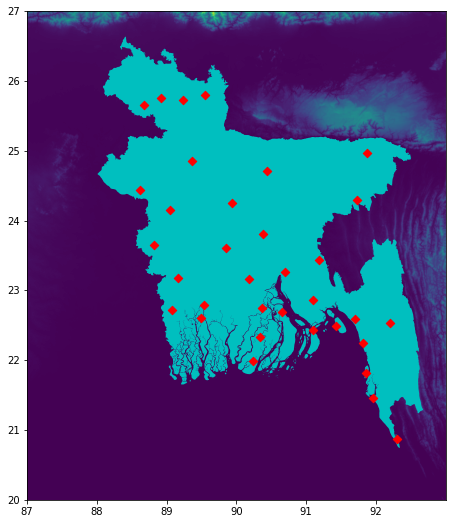

In [5]:
# Overlay temperature data on top of Bangladesh base map
gdf = gpd.read_file("data/Bangladesh_Temperature.shp")
elevation = rasterio.open("data/Bangladesh_Elevation.tif")

fig, ax = plt.subplots(figsize=(10,9))
borders.plot(ax=ax, color='c')
gdf.plot(ax=ax, marker='D', color='r')
rasterio.plot.show(elevation)
plt.show()

---
### idw_interpolation() function
Now the fun part begins. Write these few line of code from below in any python interpreter while you are on **pyidw_example** directory.
It will take a few second to complete, then a map image like below will be shown. And a new file will be created namely ***Bangladesh_Temperature_idw.tif***, this is the saved raster file of interpolated map. This file is named after input_point_shapefile name with ***\_idw.tif*** suffix. **idw_interpolation()** function take six parameters. 

- The first parameter ***input_point_shapefile=*** take an ESRI point shapefile which should contain the particular data value we are interseted to create an interpolation map. Also there shouldn't any value outside of our given extent_shapefile area. 
- The second parameter ***extent_shapefile=*** take an ESRI polygon shapefile, this shapefile is used for defining the calculation and mapping boundary. The coordinate system of extent_shapefile should be same as input_point_shapefile.
- The third parameter ***column_name=*** take the column name of particular field as a string. This is the value upon which IDW map will be created.
- The fourth parameter ***power=*** is an optional parameter with default value of 2, this is the power parameter from [idw equation](https://en.wikipedia.org/wiki/Inverse_distance_weighting#:~:text=A%20general%20form,the%20power%20parameter.).
- The fifth parameter ***search_radious=*** is also an optional parameter with default value of 4, it determines how many nearest points will be used for idw calculation.
- The sixth parameter ***output_resolution=*** is also optional with default value of 250. This parameter define the maximum height or width (which one is higher) of reasulting ***\_idw.tif*** file in pixel.

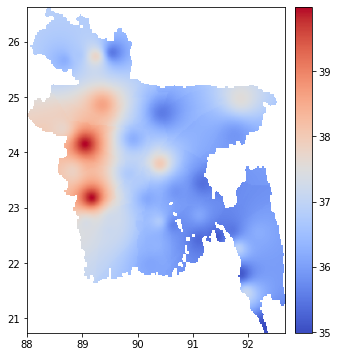

In [6]:
idw.idw_interpolation(
    input_point_shapefile="data/Bangladesh_Temperature.shp",
    extent_shapefile="data/Bangladesh_Border.shp",
    column_name="Max_Temp",
    power=2,
    search_radious=10,
    output_resolution=250,
)

---

### accuracy_standard_idw()

If you are interested in accuracy assessment of your interpolation then you could use **accuracy_standard_idw()** function from **pyidw** which take 6 parameters same as **idw_interpolation()** function. But instead of creating a idw interpolated map, the **accuracy_standard_idw()** function return tow python list. The first one contains actual data values from the input shapefile and the second list contains the interpolated values for those data points using [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) cross-validation method. Then you could compare them to obtain your desired accuracy score. An example code for **accuracy_standard_idw()** function is given below.

In [6]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

original_value, interpolated_value = idw.accuracy_standard_idw(
    input_point_shapefile="Bangladesh_Temperature.shp",
    extent_shapefile="Bangladesh_Border.shp",
    column_name="Max_Temp",
    power=2,
    search_radious=6,
    output_resolution=250,
)

print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

RMSE: 1.4013796713762847


---
## show_map()
We have also implemented a raster visualization function named **show_map()**. This function incorporates easy map visualization with a built-in colour bar and coordinate tick marks. It takes 4 parameters.

 - ***input_raster=***  take raster file name as argument. 
 - ***colormap=*** is an optional parameter which take [matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)  parameter. By changing this, you can easily alter the looks of your map image. 
 - ***image_size=*** is also an optional parameter with a default value set to 1.5 which you can change to make your resulting image larger or smaller.
 - The last parameter ***return_figure=*** is for those people who wish to alter the resulting image to their liking. by default it is set to false and **show_map()** function won't return anything other than showing the map on the screen. If set to true, then **show_map()** function will return figure, axes and color_bar to the user. We will see a detailed example of this in the next section.

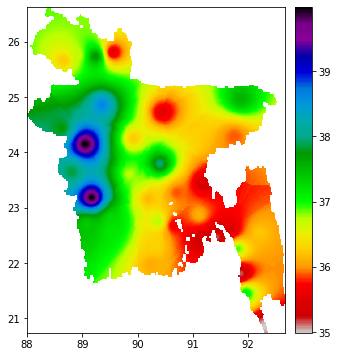

In [7]:
from pyidw import idw

idw.show_map(
    input_raster="Bangladesh_Temperature_idw.tif",
    colormap="nipy_spectral_r",
    image_size=1.5,
    return_figure=False)

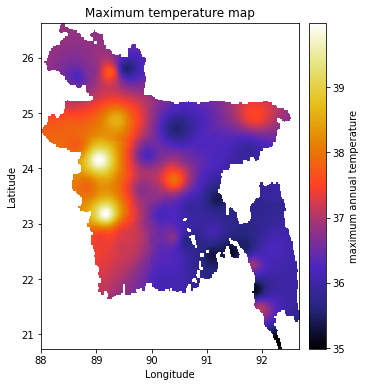

In [8]:
from pyidw import idw
from matplotlib import pyplot as plt

fig, ax, cbar = idw.show_map(
    input_raster="Bangladesh_Temperature_idw.tif",
    colormap="CMRmap",
    image_size=1.5,
    return_figure=True)

ax.set_title("Maximum temperature map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar.set_label("maximum annual temperature")
plt.show()

---
## regression_idw_interpolation()
This function is quite different than regular IDW interpolation as it incorporates external raster covariable, polynomial regression and r_squared value. This is an experimental method and we don't recommend using it as it doesn't always produce reliable output and accuracy score are also lower than regular idw interpolation. It take same parameters as ***idw_interpolation()*** function only with 2 extra parameters namely ***input_raster_file=*** which is the raster covariable.  input_raster file should be larger than ***extent_shapefile***. The other parameter is ***polynomial_degre=*** with a default value set to 1 which would define the [polynomial regression equation](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).  An example code for ***regression_idw_interpolation()*** is given below.

In [ ]:
from pyidw import idw

idw.regression_idw_interpolation(
    input_point_shapefile="Bangladesh_Temperature.shp",
    input_raster_file="Bangladesh_Elevation.tif",
    extent_shapefile="Bangladesh_Border.shp",
    column_name="Min_Temp",
    power=2,
    polynomial_degree=1,
    search_radious=5,
    output_resolution=250,
)

---
## accuracy_regression_idw()
This function is similar to **accuracy_standard_idw()**  function. An example code is given below.

In [ ]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

original_value, interpolated_value = idw.accuracy_regression_idw(
    input_point_shapefile="Bangladesh_Temperature.shp",
    input_raster_file="Bangladesh_Elevation.tif",
    extent_shapefile="Bangladesh_Border.shp",
    column_name="Min_Temp",
    power=2,
    polynomial_degree=1,
    search_radious=5,
    output_resolution=250,
)

print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))